In [1]:
%matplotlib notebook
from matplotlib import pyplot as plt
from matplotlib.figure import figaspect
import numpy as np
import os

try:
    from ncempy.io import dm
except ImportError:
    !pip install ncempy
    from ncempy.io import dm

from scipy import ndimage
from skimage import util, exposure, filters

from IPython.display import display
from ipywidgets import IntSlider, interactive

from grain_thresholding import threshold_otsu_median, threshold_otsu_median2

## High mag (5 MX) HAADF-STEM image of Pt923

In [2]:
fname = '5000000X_PJH-P1_Sq2_0107.dm3'

dm3 = dm.dmReader(fname)
im = exposure.rescale_intensity(util.img_as_float(dm3['data']))

fig, ax = plt.subplots(ncols=2, figsize=figaspect(1./2))
ax[0].matshow(im, vmax=0.4, cmap='gray')
ax[0].set_title(os.path.basename(fname), color='r')

vals, bins = exposure.histogram(im)
ax[1].plot(bins, vals)
ax[1].set_title('Intensity histogram')
ax[1].set_ylim(0, 1000)
ax[1].annotate('Cluster intensities', xy=(0.3, 200), xytext=(0.4, 400),
               arrowprops=dict(arrowstyle='->'))
ax[1].annotate('Background intensities', xy=(0.05, 600), xytext=(0.3, 600),
               arrowprops=dict(arrowstyle='->'))

<IPython.core.display.Javascript object>

Text(0.3, 600, 'Background intensities')

## The effect of different classifiers in Otsu's threshold

In [3]:
fig, ax = plt.subplots(ncols=2, figsize=figaspect(1./2))

ax[0].matshow(im, cmap='gray', vmax=0.4)

vals, bins = exposure.histogram(im)
ax[-1].plot(bins, vals)
ax[-1].axvline(filters.threshold_otsu(im), color='k', label='Otsu\'s')
ax[-1].axvline(threshold_otsu_median(im), color='r', label='Otsu\'s modal')
ax[-1].axvline(threshold_otsu_median2(im), color='g', label='Otsu\'s median')
ax[-1].set_xlabel('Intensity/ arb.')
ax[-1].set_ylabel('Counts')
ax[-1].legend()
ax[-1].set_title('Intensity histogram and threshold')

fig.tight_layout()

<IPython.core.display.Javascript object>

## Otsu's classifiers

How Otsu's algorithm can be amended using different classifiers, eg. class medians and class modes (histogram)

10.1016/j.imavis.2011.06.003

In [4]:
fns = (filters.threshold_otsu, threshold_otsu_median, threshold_otsu_median2)
labels = ('Otsu\'s', 'Otsu\'s modal', 'Otsu\'s median')

# initialize data and masks
masks = [im > fn(im) for fn in fns]

layers = []
for m in masks:
    layer = np.zeros(m.shape + (4,))
    layer[m, 0] = 0.7
    layer[m, -1] = 0.5
    layers.append(layer)

fig, ax = plt.subplots()
# plot image
ax.matshow(im, cmap='gray', vmax=0.4)
# overlay mask
ai = ax.imshow(layers[0])
ax.set_axis_off()

def update(i):
    ai.set_array(layers[i])
    ax.set_title(labels[i])

display(interactive(update, i=IntSlider(0, 0, len(layers)-1))) 

<IPython.core.display.Javascript object>

interactive(children=(IntSlider(value=0, description='i', max=2), Output()), _dom_classes=('widget-interact',)…

## How blurring affects threshold

Otsu's threshold used.

<IPython.core.display.Javascript object>


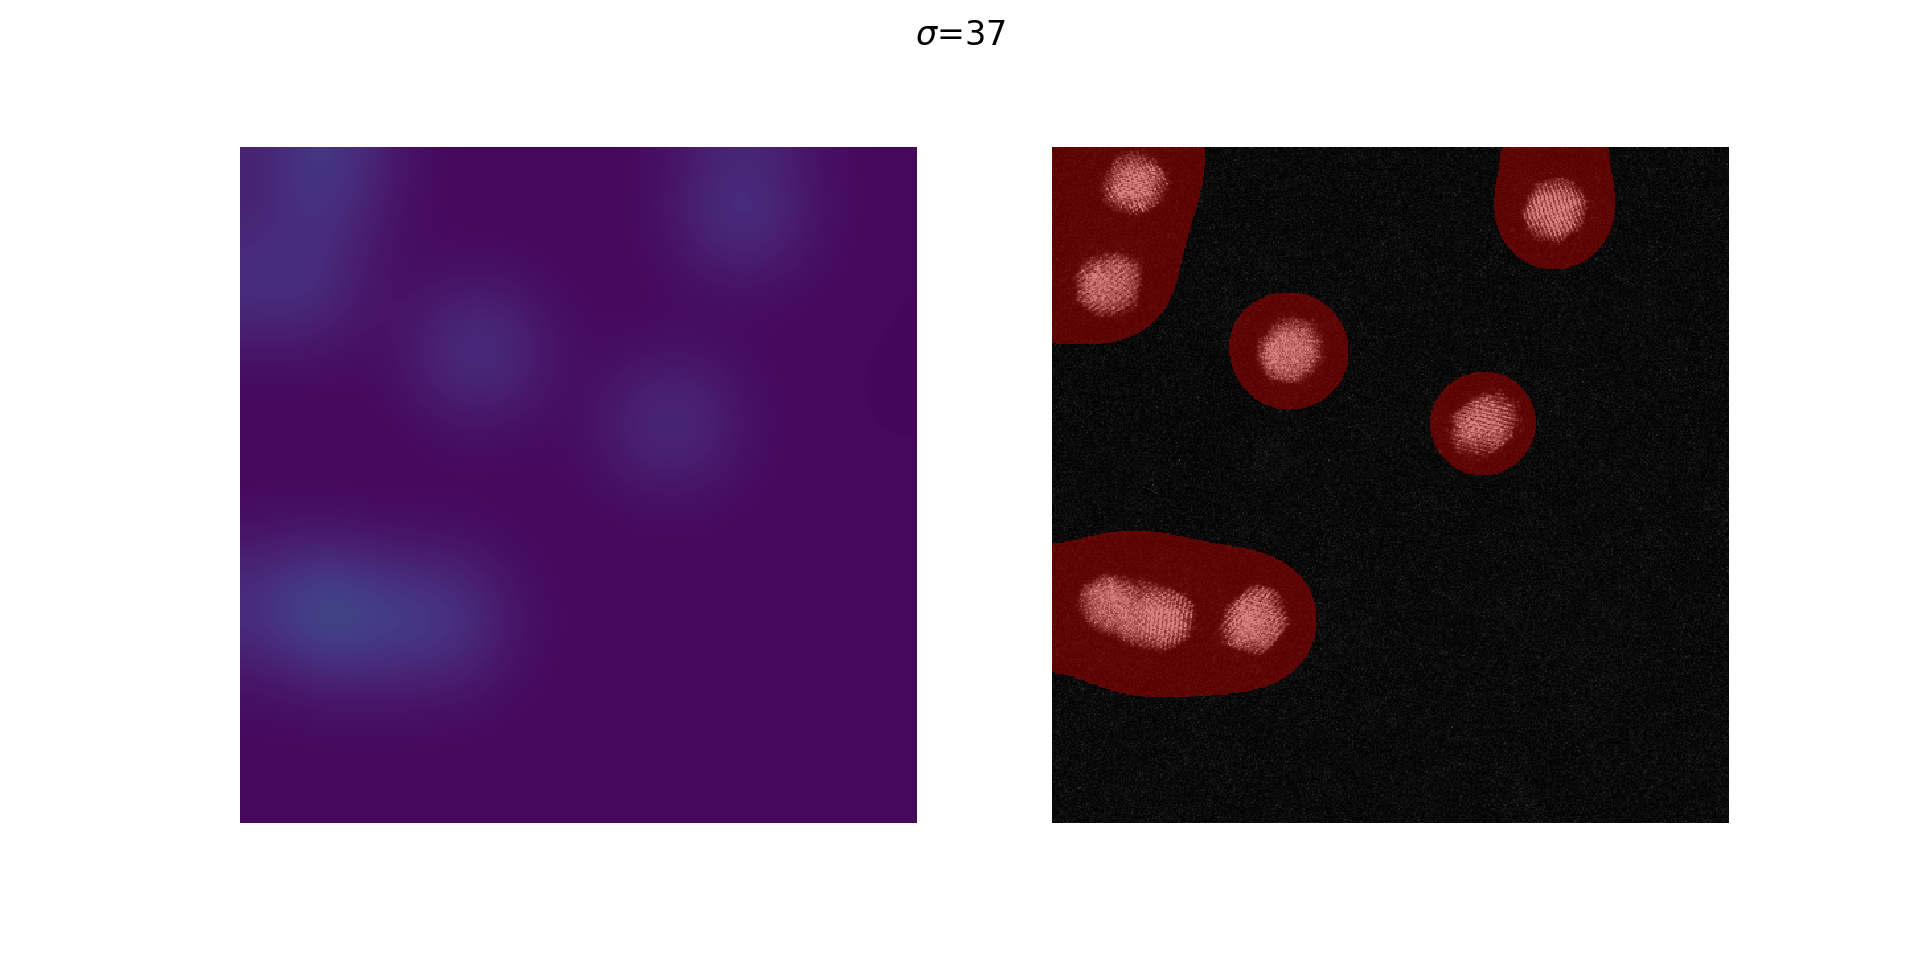

interactive(children=(IntSlider(value=0, description='i', max=50), Output()), _dom_classes=('widget-interact',…

In [7]:
from scipy import ndimage

fig, ax = plt.subplots(ncols=2, figsize=figaspect(0.5), sharex=True, sharey=True)

# initial figure setup
blurred = ndimage.gaussian_filter(im, 1)
aig = ax[0].matshow(blurred)

mask = blurred > filters.threshold_otsu(blurred)    
layer = np.zeros(im.shape + (4,))
layer[mask, 0] = 0.7
layer[mask, -1] = 0.5

ax[1].matshow(im, cmap='gray', vmax=0.4)
# overlay mask
ai = ax[1].imshow(layer)

for _ax in ax:
    _ax.set_axis_off()

# add slider
slider = IntSlider(0, 0, 50)

# do main calculations now, to save time on interact
cache = np.empty(im.shape + (slider.max-slider.min+1,), dtype=float)
for i in range(slider.max - slider.min + 1):
    cache[..., i] = ndimage.gaussian_filter(im, i)

def update(i):
    blurred = cache[..., i]
    aig.set_array(blurred)
    
    mask = blurred > filters.threshold_otsu(blurred)
    
    layer = np.zeros(im.shape + (4,))
    layer[mask, 0] = 0.7
    layer[mask, -1] = 0.5
    
    ai.set_array(layer)
    
    fig.suptitle('$\sigma$={}'.format(i))

display(interactive(update, i=slider)) 